## Fake news prediction

Učitavanje potrebnih biblioteka

In [1]:
import pandas as pd
import numpy as np
import re
import contractions
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

ModuleNotFoundError: No module named 'contractions'

Učitavanje FakeNews baze podataka koja se sastoji od 3 dijela:
- train
- test
- submit

Train se koristi za treniranje i evaluaciju modela a test i submit za ručnu provjeru valjanosti modela.

In [2]:
train = pd.read_csv('fakeNewsDataset/train.csv')
test = pd.read_csv('fakeNewsDataset/test.csv')
submit = pd.read_csv('fakeNewsDataset/submit.csv')

In [113]:
len(test)

5200

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [115]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [4]:
baza=train.fillna('') #Nan vrijednosti zamijenjene praznim stringom

Stavaranje "Content" stupca koji se sastoji od autora, naslova i cijelog teksta članka.

In [117]:
baza['content'] = baza['author'] + ' ' + baza['title'] + ' ' + baza['text']

##### Definiranje funkcija za "čišćenje" teksta

In [118]:
def cleaning(text):
    text = re.sub('[^a-zA-Z’]', ' ', text)
    text = text.lower()
    return text

Uklananje contractions-a (riječi koje su kombinacija dviju riječi npr. "do" + "not" = "don't")

In [119]:
def remove_contractions(text):
    return ' '.join([contractions.fix(word) for word in text.split()])

Uklananje kratkih rijeći (manje od 3 slova)

In [120]:
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

In [121]:
wnl = WordNetLemmatizer()
ps = PorterStemmer()
ss = SnowballStemmer(language='english')

"Stemming" funkcija pretvara riječi u njihov korijen (nije korišteno jer donosi lošije rezultate). Umjesto toga se koristi Lemmantizer.

In [122]:
def porter_stemmer(text):
    stemmed_tokens = [ps.stem(token) for token in text]
    return ' '.join(stemmed_tokens)

In [123]:
def snowball_stemmer(text):
    stemmed_tokens = [ss.stem(token) for token in text]
    return ' '.join(stemmed_tokens)

In [124]:
def lemmatize_text(text):
    lemmantized = ' '.join([wnl.lemmatize(words) for words in text])
    return lemmantized

Pokretanje defniranih funckija

In [125]:
baza['content'] = baza['content'].apply(cleaning)

In [126]:
baza['r_contr'] = baza['content'].apply(remove_contractions)

Pretvaranje teksta u tokene

In [127]:
baza['tokens'] = baza['r_contr'].apply(word_tokenize)

In [128]:
baza['r_tokens'] = baza['tokens'].apply(remove_small_words)

Funkcija za uklananje stopwords-a (zaustavnih riječi)

In [129]:
baza['r_stopwords']=baza['r_tokens'].apply(lambda x:([word for word in x if word not in (stopwords.words('english'))]))

Koristi se samo lemmatize funkcija

In [130]:
#baza['stemmed_content'] = baza['content'].apply(stemming)
#baza['snowball_stemmed'] = baza['content'].apply(snowball_stemmer)
baza['lemmatized_content'] = baza['r_stopwords'].apply(lemmatize_text)

In [131]:
#baza['lemmatized_content']=baza['lemmatized_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

Kreiranje oblaka riječi za cijelokupni tekst

In [132]:
oblak=np.array(Image.open('oblak.png'))

In [133]:
wordcloud = WordCloud( background_color='white', width=3000, height=2000, random_state=4, mask=oblak)

text_cloud = wordcloud.generate(' '.join(baza['lemmatized_content']))

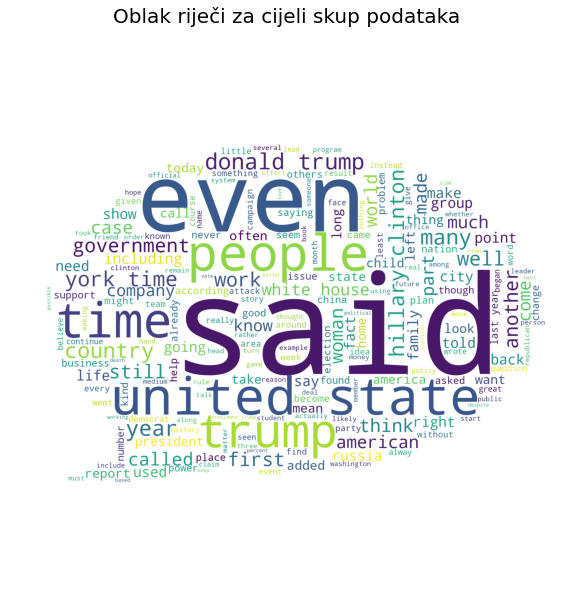

In [134]:
plt.figure(figsize=(10,20))
plt.imshow(text_cloud)
plt.axis('off')
plt.title("Oblak riječi za cijeli skup podataka", fontsize=20)
plt.show()

Kreiranje oblaka riječi posebno za istinite i lažne vijesti.
Istinite vijesti su ozačene sa brojem 0 a lažne s brojem 1.

In [5]:
bazaTrue = baza[baza['label']==0]
bazaFalse = baza[baza['label']==1]

In [7]:
len(bazaFalse)

10413

In [136]:
pie_chart=[len(bazaTrue),len(bazaFalse)]

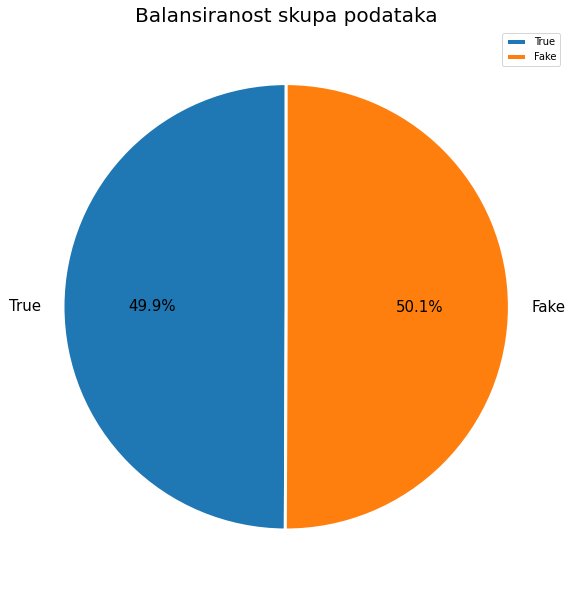

In [137]:
plt.figure(facecolor='white',figsize=(10,20))
plt.pie(pie_chart, colors=["#1f77b4", "#ff7f0e"], shadow=False, startangle=90, 
        labels=['True','Fake'], autopct='%1.1f%%', 
        textprops={'color' : 'black', 'fontsize': 15},
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'})
plt.title("Balansiranost skupa podataka", fontsize=20)
plt.legend()
plt.show() 

In [138]:
textWC_true =' '.join(bazaTrue['lemmatized_content'])

In [139]:
textWC_false =' '.join(bazaFalse['lemmatized_content'])

In [140]:
text_cloud_true = wordcloud.generate(textWC_true)

Oblak riječi za istinite vijesti

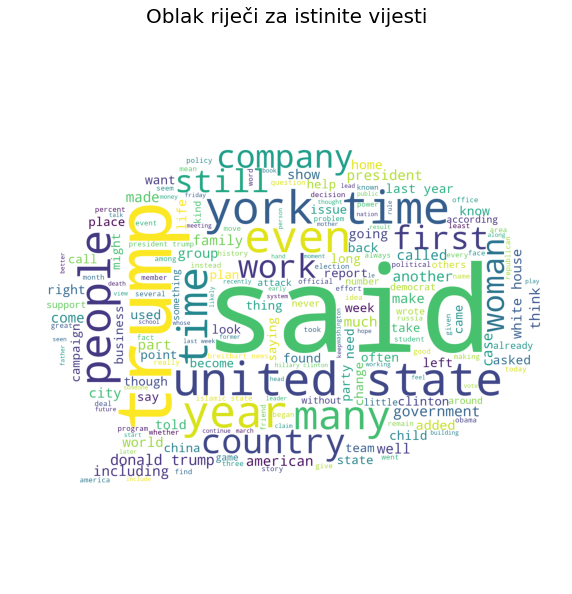

In [141]:
plt.figure(figsize=(10,20))
plt.imshow(text_cloud_true)
plt.axis('off')
plt.title("Oblak riječi za istinite vijesti", fontsize=20)
plt.show()

In [142]:
text_cloud_false = wordcloud.generate(textWC_false)

Oblak riječi za lažne vijesti

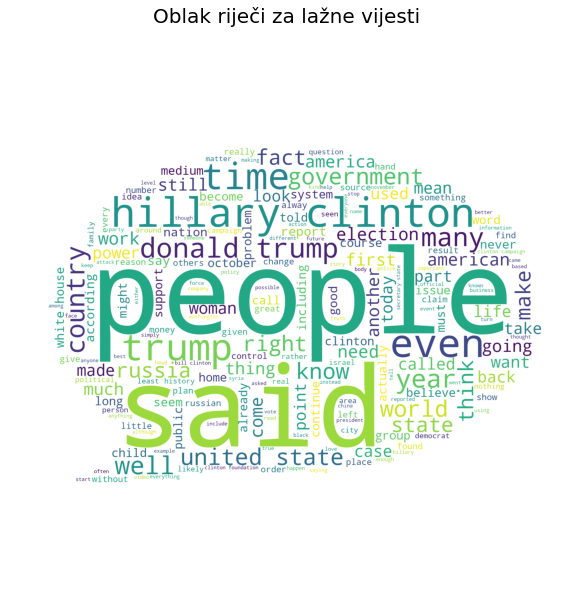

In [143]:
plt.figure(figsize=(10,20))
plt.imshow(text_cloud_false)
plt.axis('off')
plt.title("Oblak riječi za lažne vijesti", fontsize=20)
plt.show()

Definiranje varijabli X i y koje će se koristiti za strojno učenje

In [144]:
X=baza['lemmatized_content'].values #u X varijablu se pohranju vrijednosti iz stupca Content
y=baza['label'].values # u y varijablu se pohranjuju vrijednosti iz stupca label

Definiranje vectorizatora koji pretvara tekstualne vrijednosti u vektore

In [145]:
"""vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X=vectorizer.transform(X)"""

'vectorizer = TfidfVectorizer()\nvectorizer.fit(X)\nX=vectorizer.transform(X)'

In [146]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, 
analyzer='word')
X = vectorizer.fit_transform(X)

Definiranje train (75%) i test (25%) varijabli

In [148]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, stratify=y, random_state=2)

Definiranje modela strojnog učenja korištenjem raznih algoritama (Linearna i logistička regresija, stabla odluke, KNN...)

In [149]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [150]:
X_test_pred_LR = model_LR.predict(X_test)
test_accuracy_LR = accuracy_score(X_test_pred_LR, y_test)
print("Test accuracy: ", test_accuracy_LR)

Test accuracy:  0.9463461538461538


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2597
           1       0.95      0.94      0.95      2603

    accuracy                           0.95      5200
   macro avg       0.95      0.95      0.95      5200
weighted avg       0.95      0.95      0.95      5200



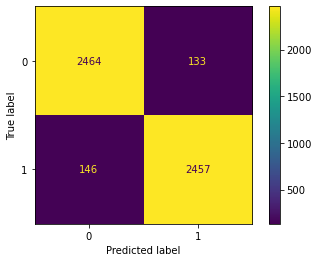

In [151]:
print(classification_report(y_test, X_test_pred_LR))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, X_test_pred_LR),
                        display_labels=model_LR.classes_).plot()
plt.show()

In [152]:
model_DT = DecisionTreeClassifier(criterion='entropy')
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [153]:
X_test_pred_DT = model_DT.predict(X_test)
test_accuracy_DT = accuracy_score(X_test_pred_DT, y_test)
print("Test accuracy: ", test_accuracy_DT)

Test accuracy:  0.9401923076923077


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2597
           1       0.94      0.94      0.94      2603

    accuracy                           0.94      5200
   macro avg       0.94      0.94      0.94      5200
weighted avg       0.94      0.94      0.94      5200



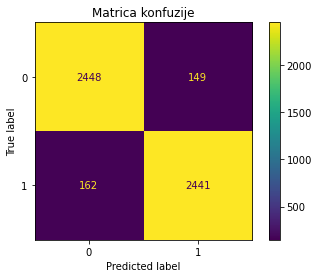

In [205]:
print(classification_report(y_test, X_test_pred_DT))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, X_test_pred_DT),
                        display_labels=model_DT.classes_).plot()
plt.title("Matrica konfuzije")
plt.show()

In [222]:
model_RF = RandomForestClassifier(criterion='entropy', n_estimators=150)#, max_depth=20)
model_RF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=150)

In [223]:
X_test_pred_RF = model_RF.predict(X_test)
test_accuracy_RF = accuracy_score(X_test_pred_RF, y_test)
print("Test accuracy: ", test_accuracy_RF)

Test accuracy:  0.9257692307692308


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2597
           1       0.96      0.89      0.92      2603

    accuracy                           0.93      5200
   macro avg       0.93      0.93      0.93      5200
weighted avg       0.93      0.93      0.93      5200



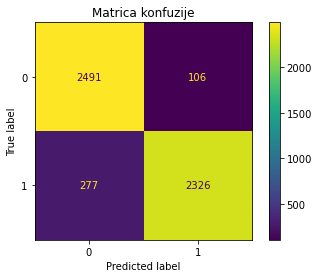

In [157]:
print(classification_report(y_test, X_test_pred_RF))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, X_test_pred_RF),
                        display_labels=model_RF.classes_).plot()
plt.title("Matrica konfuzije")
plt.show()

In [158]:
model_SVM = svm.SVC(kernel='linear')
model_SVM.fit(X_train, y_train)

SVC(kernel='linear')

In [159]:
X_test_pred_SVM = model_SVM.predict(X_test)
test_accuracy_SVM = accuracy_score(X_test_pred_SVM, y_test)
print("Test accuracy: ", test_accuracy_SVM)

Test accuracy:  0.9605769230769231


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2597
           1       0.96      0.96      0.96      2603

    accuracy                           0.96      5200
   macro avg       0.96      0.96      0.96      5200
weighted avg       0.96      0.96      0.96      5200



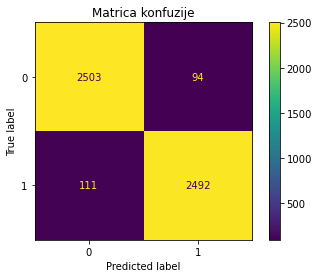

In [160]:
print(classification_report(y_test, X_test_pred_SVM))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, X_test_pred_SVM),
                        display_labels=model_SVM.classes_).plot()
plt.title("Matrica konfuzije")
plt.show()

In [161]:
model_KNN = KNeighborsClassifier(n_neighbors=2, metric='cosine', weights='distance')
model_KNN.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=2, weights='distance')

In [162]:
X_test_pred_KNN = model_KNN.predict(X_test)
test_accuracy_KNN = accuracy_score(X_test_pred_KNN, y_test)
print("Test accuracy: ", test_accuracy_KNN)

Test accuracy:  0.835


              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2597
           1       0.87      0.79      0.83      2603

    accuracy                           0.83      5200
   macro avg       0.84      0.84      0.83      5200
weighted avg       0.84      0.83      0.83      5200



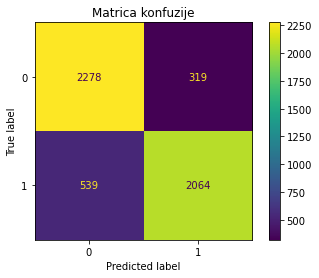

In [163]:
print(classification_report(y_test, X_test_pred_KNN))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, X_test_pred_KNN),
                        display_labels=model_KNN.classes_).plot()
plt.title("Matrica konfuzije")
plt.show()

In [164]:
model_NB = MultinomialNB()
model_NB.fit(X_train, y_train)

MultinomialNB()

In [165]:
X_test_pred_NB = model_NB.predict(X_test)
test_accuracy_NB = accuracy_score(X_test_pred_NB, y_test)
print("Test accuracy: ", test_accuracy_NB)

Test accuracy:  0.8688461538461538


              precision    recall  f1-score   support

           0       0.80      0.99      0.88      2597
           1       0.98      0.75      0.85      2603

    accuracy                           0.87      5200
   macro avg       0.89      0.87      0.87      5200
weighted avg       0.89      0.87      0.87      5200



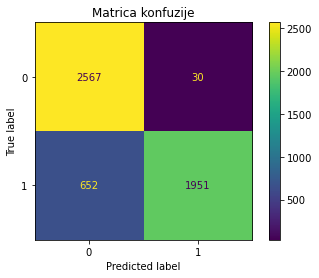

In [166]:
print(classification_report(y_test, X_test_pred_NB))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, X_test_pred_NB),
                        display_labels=model_NB.classes_).plot()
plt.title("Matrica konfuzije")
plt.show()

In [167]:
model_PA = PassiveAggressiveClassifier(max_iter=100)
model_PA.fit(X_train, y_train)

PassiveAggressiveClassifier(max_iter=100)

In [168]:
X_test_pred_PA = model_PA.predict(X_test)
test_accuracy_PA = accuracy_score(X_test_pred_PA, y_test)
print("Test accuracy: ", test_accuracy_PA)

Test accuracy:  0.9609615384615384


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2597
           1       0.96      0.96      0.96      2603

    accuracy                           0.96      5200
   macro avg       0.96      0.96      0.96      5200
weighted avg       0.96      0.96      0.96      5200



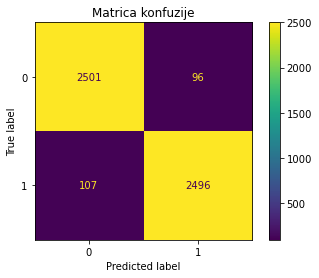

In [169]:
print(classification_report(y_test, X_test_pred_PA))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, X_test_pred_PA),
                        display_labels=model_PA.classes_).plot()
plt.title("Matrica konfuzije")
plt.show()

Definiranje riječnika u kojem su pohranjene vrijednosti točnosti algoritama strojnog učenja

In [170]:
test_dict = {
    'Logistička regresija' : [test_accuracy_LR,0.95,0.95,0.95],
    'Stablo odluke' : [test_accuracy_DT,0.94,0.94,0.94],
    'Slučajne šume' : [test_accuracy_RF,0.92,0.92,0.92],
    'SVM' : [test_accuracy_SVM,0.96,0.96,0.96],
    'KNN' : [test_accuracy_KNN,0.84,0.84,0.83],
    'Naivni Bayes' : [test_accuracy_NB, 0.89,0.89,0.87],
    'Pasivno agresivni' : [test_accuracy_PA,0.96,0.96,0.96]
    }

In [173]:
test_dict_DF = pd.DataFrame(test_dict).T

In [177]:
test_dict_DF.columns=["Tocnost","Preciznost","Odziv","F1"]

In [179]:
test_dict_DF

,Tocnost,Preciznost,Odziv,F1
Logistička regresija,0.946346,0.95,0.95,0.95
Stablo odluke,0.940192,0.94,0.94,0.94
Slučajne šume,0.926346,0.92,0.92,0.92
SVM,0.960577,0.96,0.96,0.96
KNN,0.835000,0.84,0.84,0.83
Naivni Bayes,0.868846,0.89,0.89,0.87
Pasivno agresivni,0.960962,0.96,0.96,0.96


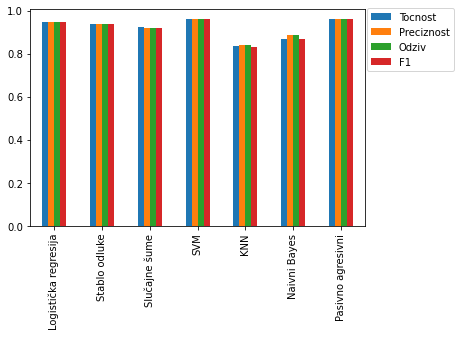

In [181]:
test_dict_DF.plot(kind="bar")
plt.legend(bbox_to_anchor=(0.99,1.025), loc="upper left")
plt.show()